In [2]:
import numpy as np
import torch
import scipy
import time

import sys
sys.path.insert(1, './PSM_V1')
from sobolev import Sobolev
from solver import Solver
from utils import matmul
from diffeomorphisms import hyper_rect
import surrogates
import matplotlib.pyplot as plt
sys.path.insert(1, './PINN_Dominik')
from pinnutils import PINN
#from pinnutils import PINNN

In [3]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

In [4]:
# Tests
# a=-1.0, b=1.0, q=3, sob_2d(deg=30), sob_1d(deg=100), model(n=30, p=np.inf), s=[0,-1], optimizer:LBFGS

### 2D Poisson Equation
$$
    \partial_x^k u +\partial_y^ku = f_k(x), \forall x\in\Omega,\textrm{ with }k\in\{1,2,3,4\}\,,
\end{equation}
$$

In [5]:
rect = np.array([[-1.0, 1.0], [-1.0, 1.0]])

q = 1
lam = 2*np.pi*q

def f1(x,y):
    return lam*np.cos(lam*x)*np.cos(lam*y)- lam*np.sin(lam*x)*np.sin(lam*y)
def f2(x,y):
    return -2*lam**2*np.cos(lam*x)*np.sin(lam*y)
def f3(x,y):
    return lam**3*np.sin(lam*x)*np.sin(lam*y)- lam**3*np.cos(lam*x)*np.cos(lam*y)
def f4(x,y):
    return 2*lam**4*np.cos(lam*x)*np.sin(lam*y)

In [6]:
# Sobolev Cubature
diffeo_2d = hyper_rect(*rect)
diffeo_1d_0 = hyper_rect(rect[0])
diffeo_1d_1 = hyper_rect(rect[1])

sob_2d = Sobolev(deg=30, dim=2, diffeo=diffeo_2d)
sob_1d_0 = Sobolev(deg=100, diffeo=diffeo_1d_0)
sob_1d_1 = Sobolev(deg=100, diffeo=diffeo_1d_1)

dx, dy = torch.tensor(sob_2d.diff.diffs(np.array([[1,0],[0,1]])), dtype = torch.float32)
dx2, dy2 = torch.tensor(sob_2d.diff.diffs(np.array([[2,0],[0,2]])), dtype = torch.float32)
dx3, dy3 = torch.tensor(sob_2d.diff.diffs(np.array([[3,0],[0,3]])), dtype = torch.float32)
dx4, dy4 = torch.tensor(sob_2d.diff.diffs(np.array([[4,0],[0,4]])), dtype = torch.float32)

### Ground Truth

In [7]:
def gt(x,y):
    return np.cos(lam*x)*np.sin(lam*y)

### Gradient Flow

In [8]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# For that use:
# -> sob.set_s(s)
# -> sob.metric(rev=False/True, weak=False/True)

In [9]:
# Sobolev Order
sob_2d.set_s(0)
sob_1d_0.set_s(0)

In [10]:
# Data
_, xs_bndr_0 = sob_1d_0.get_xs()
_, xs_bndr_1 = sob_1d_1.get_xs()
xs_plt, xs = sob_2d.get_xs()
leja_grid_2d = sob_2d.get_leja_grid()
xs = torch.tensor(xs)
xs_bdx =  torch.tensor(xs_bndr_0[0])
X_t, Y_t = torch.meshgrid(xs[0],xs[1])
X_pde = torch.tensor(torch.cat((X_t.reshape(-1,1), Y_t.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
X_bdl = torch.tensor(torch.cat((xs_bdx.reshape(-1,1), rect[1][0]*torch.ones(len(xs_bdx)).reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
X_bdr = torch.tensor(torch.cat((xs_bdx.reshape(-1,1), rect[1][1]*torch.ones(len(xs_bdx)).reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
Y_bdl = torch.tensor(torch.cat((rect[0][0]*torch.ones(len(xs_bdx)).reshape(-1,1),xs_bdx.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
Y_bdr = torch.tensor(torch.cat((rect[0][1]*torch.ones(len(xs_bdx)).reshape(-1,1),xs_bdx.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
def f_ubdy(gt, f):
    u_bdxl = torch.tensor(gt(xs_bndr_0[0], rect[1][0].reshape(-1)), dtype = torch.float32)
    u_bdxr = torch.tensor(gt(xs_bndr_0[0], rect[1][1].reshape(-1)), dtype = torch.float32)
    u_bdyl= torch.tensor(gt(rect[0][0].reshape(-1,1), xs_bndr_1[0]).reshape(-1), dtype = torch.float32)
    u_bdyr= torch.tensor(gt(rect[0][1].reshape(-1,1), xs_bndr_1[0]).reshape(-1), dtype = torch.float32)
    fXY = f(X_t,Y_t).reshape(-1)
    return [ u_bdxl, u_bdxr,  u_bdyl,  u_bdyr], fXY
w_2d = torch.tensor(sob_2d.get_leja_weights(), dtype = torch.float32)
w_1d = torch.tensor(sob_1d_0.get_leja_weights(), dtype = torch.float32)

/tmp/ipykernel_73868/2503649402.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  xs = torch.tensor(xs)
/trinity/shared/pkg/devel/python/3.10.4/venv/venv_a/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_73868/2503649402.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_pde = torch.tensor(torch.cat((X_t.reshape(-1,1), Y_t.reshape(-1,1)),1), dtype = torch.f

In [11]:
#Sobolev Metrics
metric_2d = sob_2d.metric(weak=True)
metric_1d_0 = sob_1d_0.l2_metric()
metric_1d_1 = sob_1d_1.l2_metric()

# Formulation
K1 = dx  +  dy
K2 = dx2 + dy2
K3 = dx3 + dy3
K4 = dx4 + dy4
eq = lambda u, K, F: matmul(K, u)+ F
#grad_dmn = lambda u: 2*matmul(K.T, metric_2d(eq(u)))
#grad_bndr_0 = lambda u: 2*metric_1d_0(u-u_bndr_0)
#grad_bndr_1 = lambda u: 2*metric_1d_1(u-u_bndr_1)

In [12]:
TD = np.concatenate([X_pde.detach().numpy(),X_bdl.detach().numpy(), X_bdr.detach().numpy(), Y_bdl.detach().numpy() , Y_bdl.detach().numpy()], 0)
# compute mean and std of training data
X_mean = torch.tensor(np.mean(TD, axis=0, keepdims=True),device=device)
X_std = torch.tensor(np.std(TD, axis=0, keepdims=True),device=device)
seedc = 1

In [13]:
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from scipy.interpolate import griddata
from itertools import product, combinations

from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from tqdm import tqdm_notebook as tqdm 
class sine(nn.Module):
    def forward(self,x):
        return torch.sin(x)


In [14]:
def closure(optim):
        optim.zero_grad()
        loss.backward()
        return loss

In [15]:
[ u_bdxl, u_bdxr,  u_bdyl,  u_bdyr], fXY = f_ubdy(gt, f4)
Kx = K4
lam_s = torch.max(torch.linalg.eig(dx4)[0].real)

In [16]:
X_test, Y_test = torch.meshgrid(torch.linspace(-1,1,100),torch.linspace(-1,1,100))
X_T = torch.cat((X_test.reshape(-1,1), Y_test.reshape(-1,1)),1) 

In [22]:
%%time
net = PINN(sizes=[2,50,50,50,50,1], mean=X_mean, std=X_std, seed=seedc, activation=sine()).to(device)
print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))
n_epochs   = 30000
lamb  = 1
losses_bc  = [];
losses_reg = [];
LOSS_T = []
params = [{'params': net.parameters()}]
milestones = [[15000,25000]]
optimizer = torch.optim.Adam(params)
scheduler = MultiStepLR(optimizer, milestones[0], gamma=0.1)
start_time = time.time()
ds = 1
for epoch in range(n_epochs):
    
    optimizer.zero_grad()
    uhat  = net(X_pde).T[0]
    #l_pde   = crit_pde(uhat)
    l_pde = torch.sum(((eq(uhat, Kx, -fXY))**2*w_2d))
    
    ###Validation loss 
    uhat  = net(X_T)
    rec_res   = uhat.T[0]-gt(X_test,Y_test).reshape(-1)
    l_reg_test  = torch.mean(abs(rec_res))
    ##
    predxl = net(X_bdl).T[0]
    predxr = net(X_bdr).T[0]
    predyl = net(Y_bdl).T[0]
    predyr = net(Y_bdr).T[0]
    #l_bc = crit_bdxl(predxl) + crit_bdxr(predxr) + crit_bdyl(predyl) + crit_bdyr(predyr) 
    l_bc = torch.sum((((predxl-u_bdxl))**2*w_1d))+torch.sum((((predxr-u_bdxr))**2*w_1d))+torch.sum((((predyl-u_bdyl))**2*w_1d))
    l_bc += torch.sum((((predyr-u_bdyr))**2*w_1d))
    
    loss = l_pde/(lam_s)+ 2*l_bc
    losses_bc.append(l_bc.item())
    losses_reg.append(l_pde.item())
    LOSS_T.append(l_reg_test.item())
    
    #loss.backward()
    optimizer.step(
                lambda: closure(
                    optimizer,
                ))
    scheduler.step()
    
    print("epoch {}/{}, loss={:.10f}, lambda={:.4f}, lr={:,.5f}\t\t\t"
          .format(epoch+1, n_epochs, loss.item(), lamb, optimizer.param_groups[0]['lr']), end="\r")
        
elapsed_time = time.time() - start_time
print('CPU time = ',elapsed_time)

#parameters: 7851
CPU time =  253.76236844062805180272, lambda=1.0000, lr=0.00001			
CPU times: user 23min 40s, sys: 31.8 s, total: 24min 12s
Wall time: 4min 13s


pred rel. linf-error = 2.576735e-01
pred rel. l2-error = 8.012135e-02
pred_rel_std. linf-error = 6.720861e-02


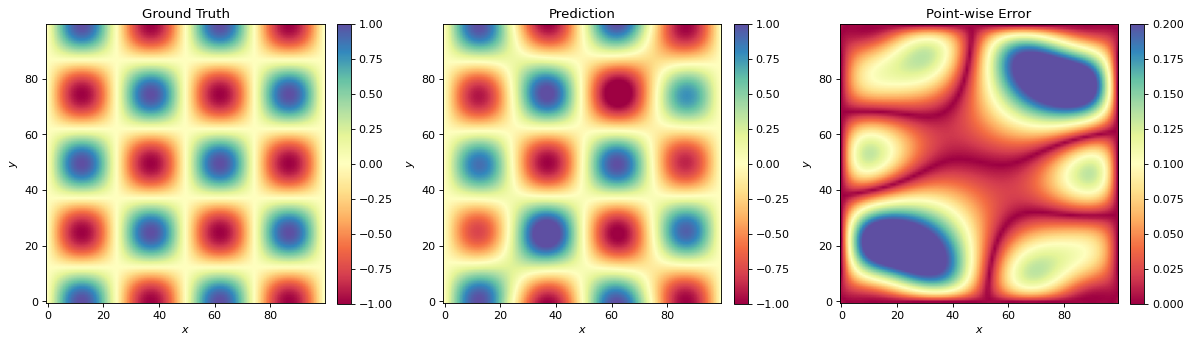

In [23]:
plt.figure(figsize=(15, 25), dpi=80)
u_sol = gt(X_test,Y_test).detach().numpy()
out = net(X_T).reshape(100,100).detach().numpy()
#out = N_p()._eval(X_r).reshape(100,100)
L0_inf = np.max(abs(out.reshape(-1)-u_sol.reshape(-1)))
#Lp_inf = torch.max(abs(poisson_residual(net_s(inp_r),inp_r,omega).reshape(-1)))
L0_mean =np.mean(abs(out.reshape(-1)-u_sol.reshape(-1)))
print("pred rel. linf-error = {:e}".format(L0_inf))
print("pred rel. l2-error = {:e}".format(L0_mean))
#print("pde res. linf-error = {:e}".format(Lp_inf))
print("pred_rel_std. linf-error = {:e}".format(np.std(abs(out.reshape(-1)-u_sol.reshape(-1)))))
plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
plt.clim(-1,1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
#plt.xticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
#plt.yticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
plt.clim(-1,1)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol), cmap="Spectral", origin="lower")
#plt.xticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
#plt.yticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.clim(0,0.2)
plt.colorbar(fraction=0.046, pad=0.04)

#plt.gcf().set_size_inches(14,4)
plt.tight_layout()
#plt.savefig(folder + 'pred_error_MSE.png',bbox_inches='tight')